# Project 2 - Consulting Project on Housing Data in King County, WA 

### Proposal to real estate developer in developing optimized house-building strategy

<br>

**Consultant Names:** Andy Nguyen, Juliet Day, Xibei(Julian) He <br>

**Date:** May 12, 2022



## Business Understanding

## Data Understanding

## Business Problem

### Import Packages

In [316]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from patsy import dmatrices


In [317]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Data Exploration and  Preparation

In [318]:
df = pd.read_csv('data/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0000,3,1.0000,1180,5650,1.0000,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0000,98178,47.5112,-122.2570,1340,5650
1,6414100192,12/9/2014,538000.0000,3,2.2500,2570,7242,2.0000,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0000,98125,47.7210,-122.3190,1690,7639
2,5631500400,2/25/2015,180000.0000,2,1.0000,770,10000,1.0000,NO,NONE,Average,6 Low Average,770,0.0,1933,nan,98028,47.7379,-122.2330,2720,8062
3,2487200875,12/9/2014,604000.0000,4,3.0000,1960,5000,1.0000,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0000,98136,47.5208,-122.3930,1360,5000
4,1954400510,2/18/2015,510000.0000,3,2.0000,1680,8080,1.0000,NO,NONE,Average,8 Good,1680,0.0,1987,0.0000,98074,47.6168,-122.0450,1800,7503


<AxesSubplot:xlabel='price'>

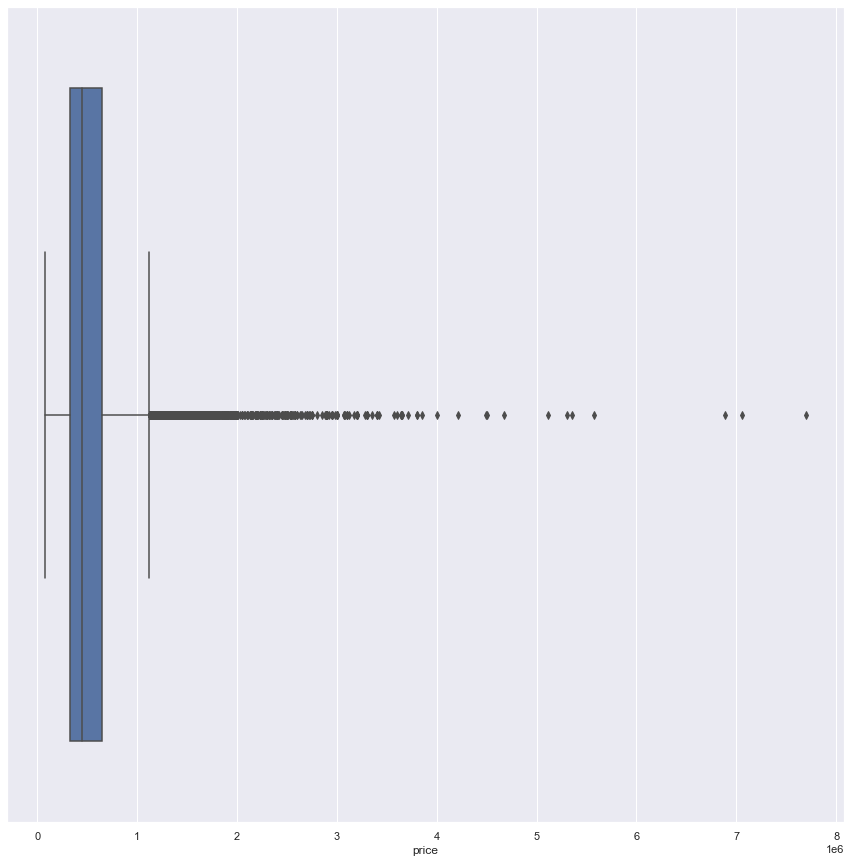

In [319]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.boxplot(x= df["price"])

In [320]:
# make a copy and clean the data for modeling 
df_copy = df.copy()
df_copy = df_copy.drop_duplicates(subset= ['id'], keep = "last")
df_copy['grade'] = df_copy["grade"].str.split(" ").str[0].astype('int64')
df_copy = df_copy.loc[(df_copy['grade'] != 13) & (df_copy['grade'] != 3) & (df_copy["grade"] != 4)]
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Poor", '1'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Fair", '2'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Average", '3'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Very Good", '5'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Good", '4'))
df_copy['condition'] = df_copy["condition"].astype("int64")
df_copy = df_copy.drop(['sqft_basement', 'yr_renovated', 'id', 'date', 'waterfront', 'view'], axis=1)

q3, q1 = np.percentile(df_copy['price'], [75, 25])
q3, q1
iqr = q3-q1
lower_limit = df_copy['price'].mean() - (iqr*1.5)
upper_limit = df_copy['price'].mean() + (iqr*1.5)
lower_limit, upper_limit

df_copy = df_copy[df_copy['price'] < upper_limit]

## Model Construction

## Linear Regression Assumptions Test Functions

### Linearity Test

In [321]:
# modified from Jeff Macaluso's code regarding linear assumption testing

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the dependent variable. 
    """
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.set(rc = {'figure.figsize':(12,10)})
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height = 9)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

### Normality Test

In [322]:
def normality(model, features, label):
    
    preds = model.predict(features)
    residuals = (label - preds)
    sns.set(rc = {'figure.figsize':(12,10)})
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);
    
    return

###  Multicollinearity Test

In [323]:
def vif(features, label):
    
    label, features = dmatrices('label ~ features', data=training_data, return_type='dataframe')
    
    # make empty VIF dataframe
    vif = pd.DataFrame()
    vif["feature"] = features.columns

    # calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

    return vif

###  Multicollinearity Test for New Model

In [324]:
def vif_new(feature, label):
    
    y, X = dmatrices('y ~ X', data=df_test, return_type='dataframe')
    
    # make empty VIF dataframe
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    
    # calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif = vif[vif['feature']!='intercept']

    return vif

### Homoscedasticity Test

In [325]:
def homoscedasticity(model, features, label):

    fig, ax = plt.subplots(figsize=(20, 18))

    
    preds = model.predict(features)
    residuals = (label - preds)
    
    ax.scatter(preds, residuals, alpha=0.5)
    ax.plot(preds, [0 for i in range(len(features))])
    ax.set_xlabel("Predicted Value")
    ax.set_ylabel("Actual - Predicted Value");

    return

## Build a baseline Model

In [326]:
training_data = df_copy.sample(frac = 0.75, random_state=25)
x_train = training_data.drop('price', axis=1)
y_train = training_data['price']

testing_data = df_copy.drop(training_data.index)
x_test = testing_data.drop('price', axis =1)
y_test = testing_data['price']

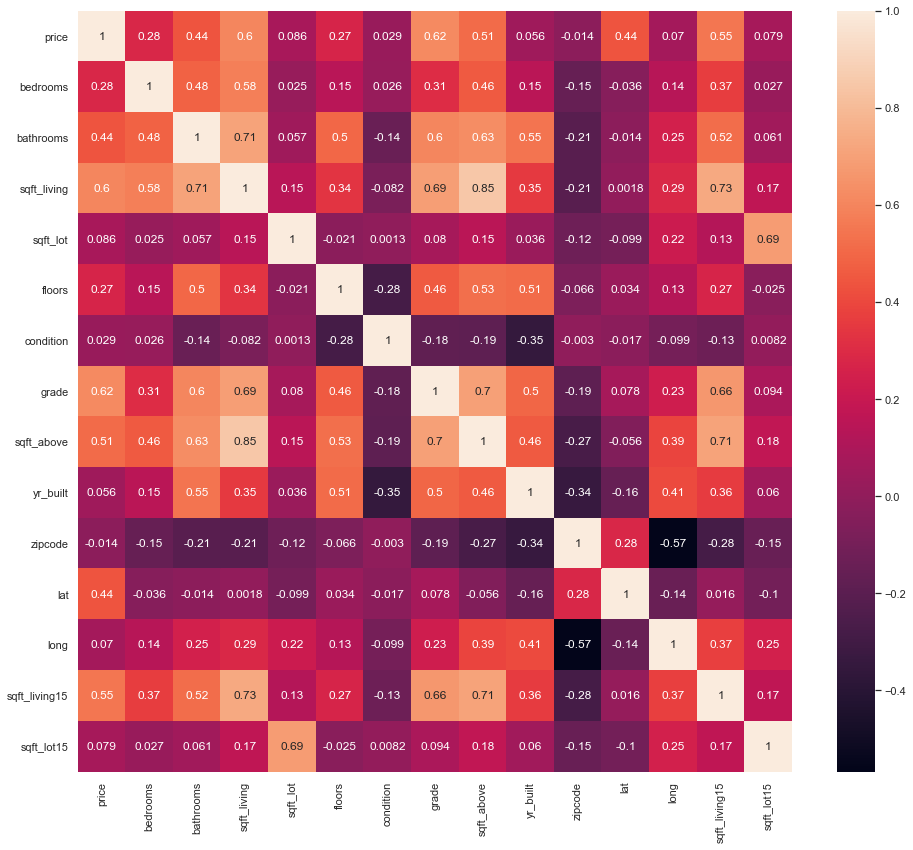

In [327]:
heatmap_data = pd.concat([y_train, x_train], axis=1)
corr = heatmap_data.corr()
sns.set(rc={'figure.figsize':(16, 14)})
sns.heatmap(data=corr, annot=True);

In [329]:
price_corrs = heatmap_data.corr()['price'].map(abs).sort_values(ascending=False)
price_corrs

price           1.0000
grade           0.6188
sqft_living     0.6046
sqft_living15   0.5495
sqft_above      0.5145
bathrooms       0.4403
lat             0.4379
bedrooms        0.2831
floors          0.2701
sqft_lot        0.0861
sqft_lot15      0.0791
long            0.0697
yr_built        0.0558
condition       0.0293
zipcode         0.0139
Name: price, dtype: float64

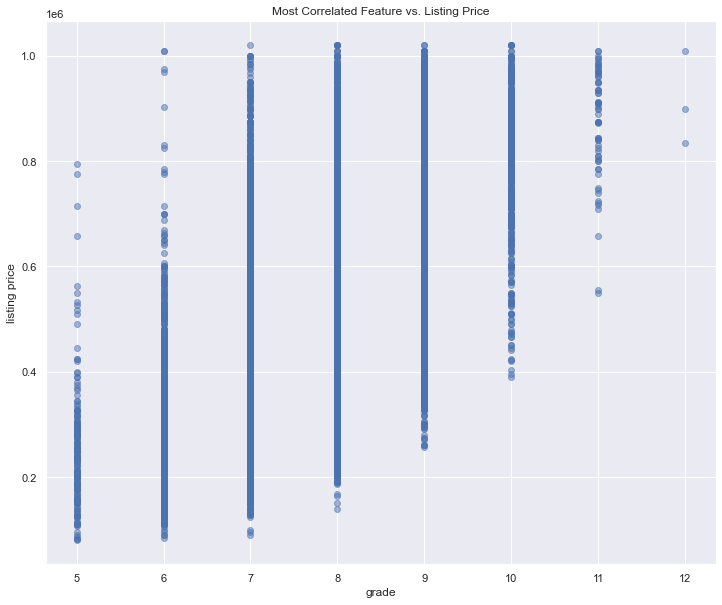

In [330]:
# Start with the simpliest variable grade and build our baseline model
most_correlated_feature = "grade"
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(x_train[most_correlated_feature], y_train, alpha=0.5)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("listing price")
ax.set_title("Most Correlated Feature vs. Listing Price");

In [331]:
baseline_model = LinearRegression()
splitter = ShuffleSplit(n_splits=3, test_size=0.75, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=x_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

baseline_model = LinearRegression()

# Fit the model on X_train_final and y_train
baseline_model = baseline_model.fit(x_train[[most_correlated_feature]], y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
# print("The test score is: ", baseline_model.score(x_test[[most_correlated_feature]], y_test))


Train score:      0.3854925641762302
Validation score: 0.381568978173713


### Running Assumption Tests on Baseline Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


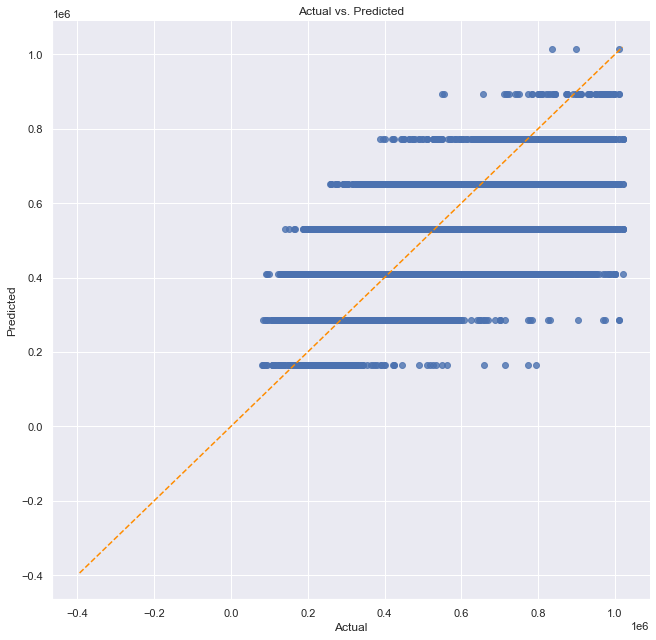

In [332]:
# becasue it is 
linear_assumption(baseline_model, x_train[[most_correlated_feature]], y_train)

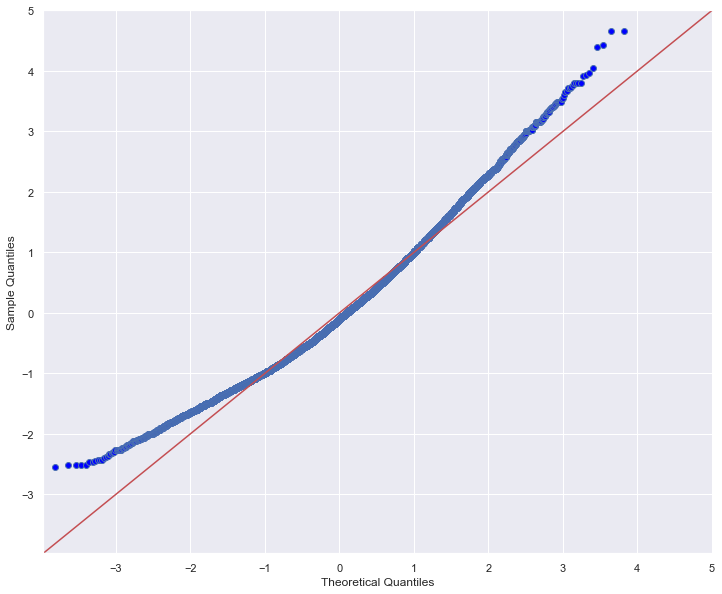

In [333]:
normality(baseline_model, x_train[[most_correlated_feature]], y_train)

We do not need to run multicollinearity and homoscedasticity tests on baseline model because it is a single variable regression.

Keep exploring the rest of columns.

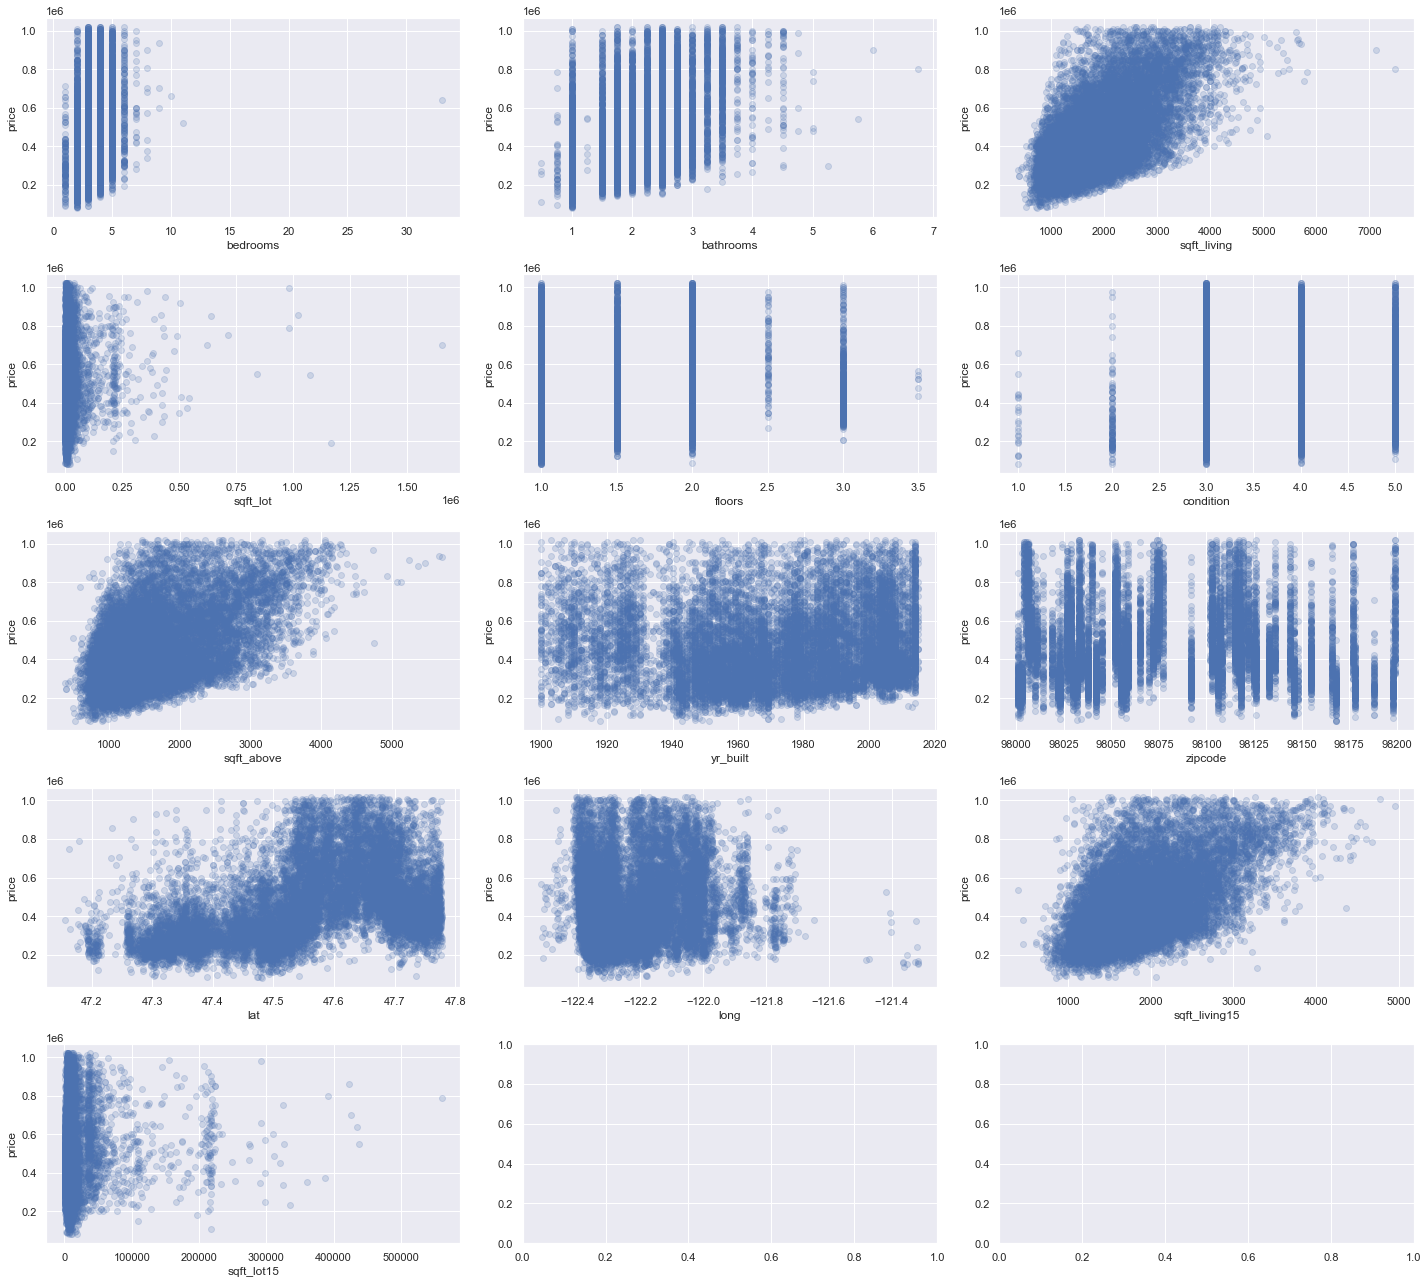

In [334]:
x_train_numeric = x_train.copy()
scatterplot_data = x_train_numeric.drop("grade", axis=1)

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 18))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(x_train_numeric[col], y_train, alpha=0.2) 
    ax.set_xlabel(col)
    ax.set_ylabel("price")

### Running the second model

In [336]:
# based on heatmap, we dropped variables that have correlation over 0.7 with another independent variables to minimize 
# multicollinearity. 

x_train_second_model = x_train_numeric.drop('bathrooms', axis=1).copy()
x_train_second_model = x_train_second_model.drop('sqft_living15', axis=1).copy()
x_train_second_model = x_train_second_model.drop('sqft_above', axis=1).copy()
x_train_second_model.head(5)

,bedrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,lat,long,sqft_lot15
13434,4,1880,3720,1.5000,4,7,1924,98109,47.6431,-122.3560,4095
985,4,2130,8560,1.0000,3,7,1992,98022,47.1949,-122.0100,8560
3993,4,2530,5000,1.5000,5,8,1917,98103,47.6624,-122.3480,3600
10377,4,2390,9638,2.0000,3,10,1988,98029,47.5598,-122.0180,9258
847,3,4000,11894,1.0000,3,9,1987,98011,47.7738,-122.2030,8650


In [337]:
second_model = LinearRegression()
second_model = second_model.fit(x_train_second_model, y_train)

second_model_scores = cross_validate(
    estimator=second_model,
    X=x_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)
print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6693512695470417
Validation score: 0.6643748022712099

Baseline Model
Train score:      0.3854925641762302
Validation score: 0.381568978173713


### Running Assumption Tests on the 2nd Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


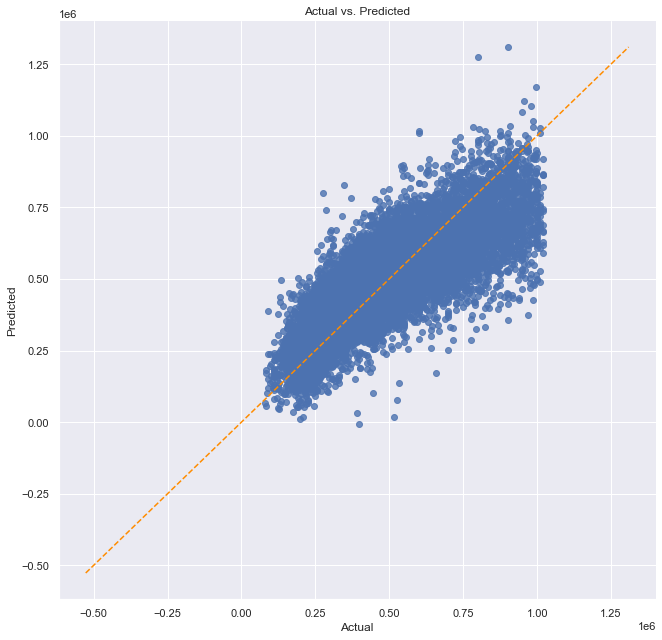

In [338]:
linear_assumption(second_model, x_train_second_model, y_train)

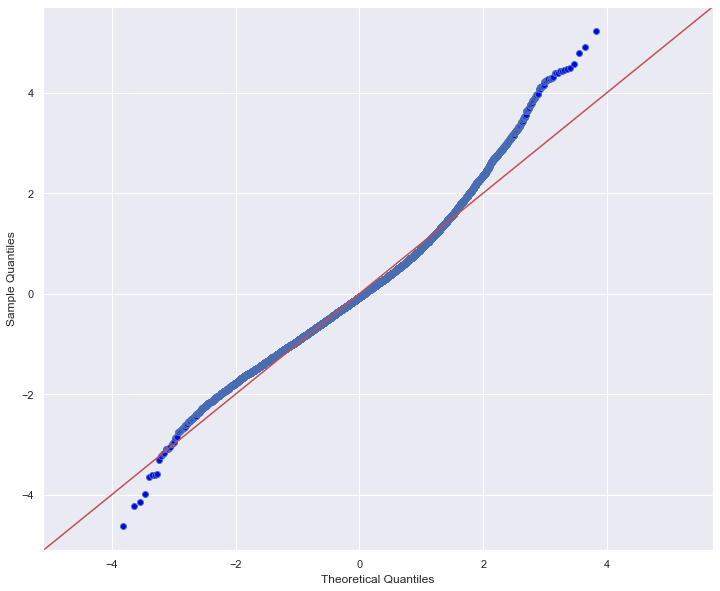

In [339]:
normality(second_model, x_train_second_model, y_train)

In [340]:
vif(x_train_second_model, y_train)

,feature,VIF
0,Intercept,4218701.6397
1,features[0],1.5725
2,features[1],2.8257
3,features[2],1.9110
4,features[3],1.5312
5,features[4],1.1909
6,features[5],2.4323
7,features[6],2.0118
8,features[7],1.6343
9,features[8],1.1505


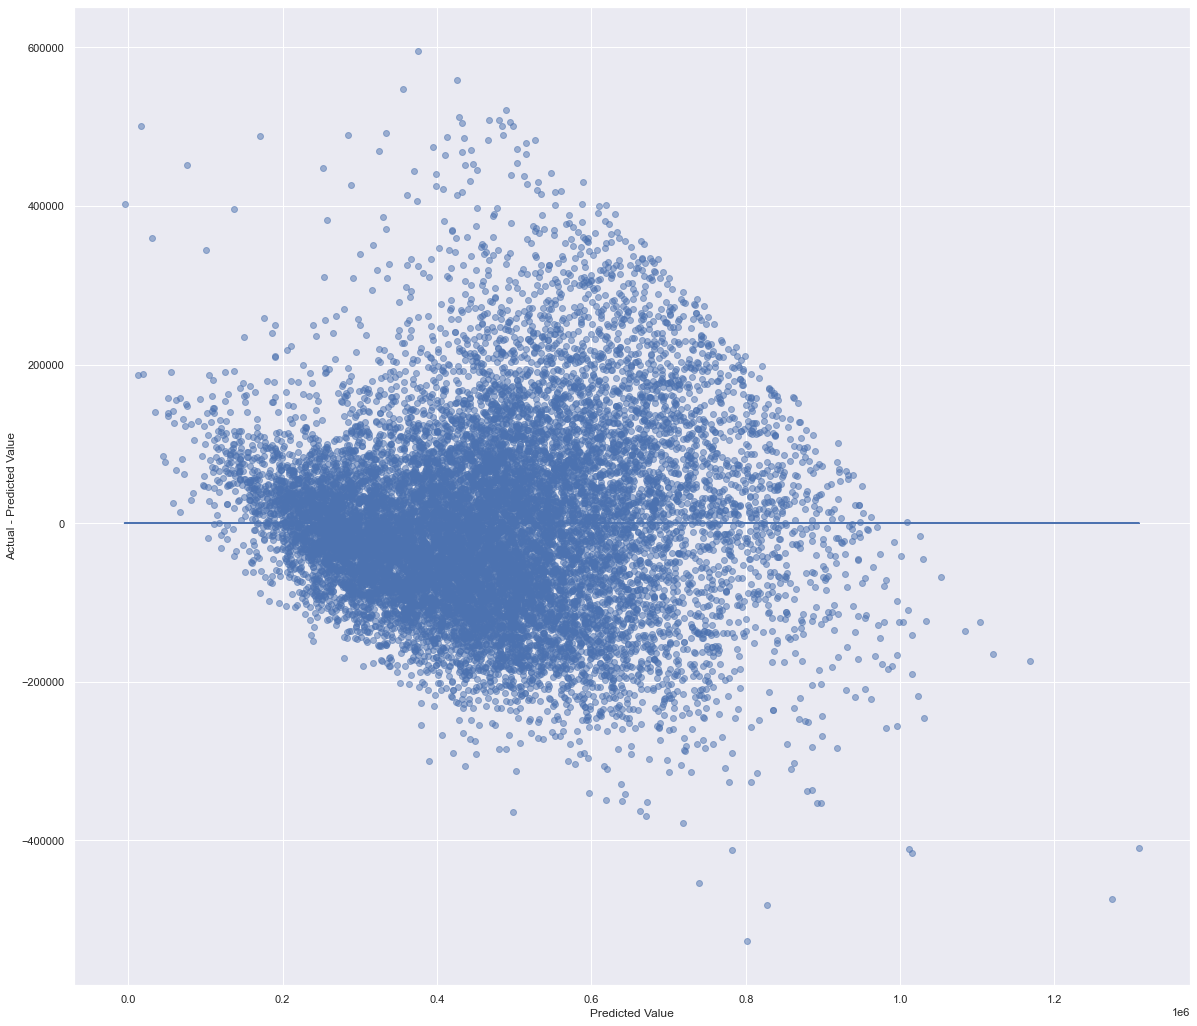

In [341]:
homoscedasticity(second_model, x_train_second_model, y_train)

#### Our 2nd model perform relatively well under assumtion tests, so the model has achieved statistical significance 
#### with R-squared = 66.4%. We will keep tuning our model to improve R-squared number. 

### Select the Best Combinations of Features

In [342]:
sm.OLS(y_train, sm.add_constant(x_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2728.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        22:03:22   Log-Likelihood:            -1.9577e+05
No. Observations:               14986   AIC:                         3.916e+05
Df Residuals:                   14974   BIC:                         3.917e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.437e+06   1.92e+06     -3.361      0.001   -1.02e+07   -2.68e+06
bedrooms    -8925.0956   1281.490     -6.965      0.000   -1.14e+04   -6413.219
sqft_living   102.0327      2.070     49.295      0.000      97.976     106.090
sqft_lot        0.2057      0.031      6.635      0.000       0.145       0.266
floors       3.446e+04   2150.702     16.024      0.000    3.02e+04    3.87e+04
condition    2.407e+04   1570.391     15.329      0.000     2.1e+04    2.72e+04
grade        8.303e+04   1443.421     57.524      0.000    8.02e+04    8.59e+04
yr_built    -1748.0985     45.445    -38.466      0.000   -1837.177   -1659.020
zipcode      -195.7649     22.343     -8.762      0.000    -239.559    -151.971
lat          5.252e+05   7055.513     74.432      0.000    5.11e+05    5.39e+05
long        -2.985e+04   8567.356     -3.485      0.000   -4.66e+04   -1.31e+04
sqft_lot15     -0.0185      0.050     -0.368      0.713      -0.117       0.080
==============================================================================
Omnibus:                     1146.033   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.548
Skew:                           0.585   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                     2.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Run the 3rd Model

In [343]:
# drop p-value > 0.05, so sqft_lot15 will be dropped.

significant_features = ['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 
                        'condition', 'grade', 'yr_built', 'zipcode', 'lat', 'long'] 
third_model = LinearRegression()
x_train_third_model = x_train[significant_features]

third_model_scores = cross_validate(
    estimator=third_model,
    X=x_train_third_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())
print()
print("Second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6691562834412729
Validation score: 0.6646815390133285

Second Model
Train score:      0.6693512695470417
Validation score: 0.6643748022712099

Baseline Model
Train score:      0.3854925641762302
Validation score: 0.381568978173713


### RFE approach

In [344]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
x_train_for_RFECV = StandardScaler().fit_transform(x_train_third_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(x_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(x_train_third_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
sqft_living: True
sqft_lot: True
floors: True
condition: True
grade: True
yr_built: True
zipcode: True
lat: True
long: True


In [345]:
best_features = significant_features
x_train_final = x_train[best_features]
x_test_final = x_test[best_features]

final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model = final_model.fit(x_train_final, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
print("The test score is: ", final_model.score(x_test_final, y_test))
print("The RMSE for the test is: ", mean_squared_error(y_test, final_model.predict(x_test_final), squared=False))

The test score is:  0.6717980155783607
The RMSE for the test is:  112243.7457638945


In [346]:
print(pd.Series(final_model.coef_, index=x_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

bedrooms       -8896.8970
sqft_living      101.9685
sqft_lot           0.1982
floors         34498.7206
condition      24063.6969
grade          83035.5763
yr_built       -1748.0459
zipcode         -195.8071
lat           525249.1128
long          -30184.4161
Name: Coefficients, dtype: float64

Intercept: -6477958.174080452


### Running Assumption Tests For the Final Model Before One Hot Encoder

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


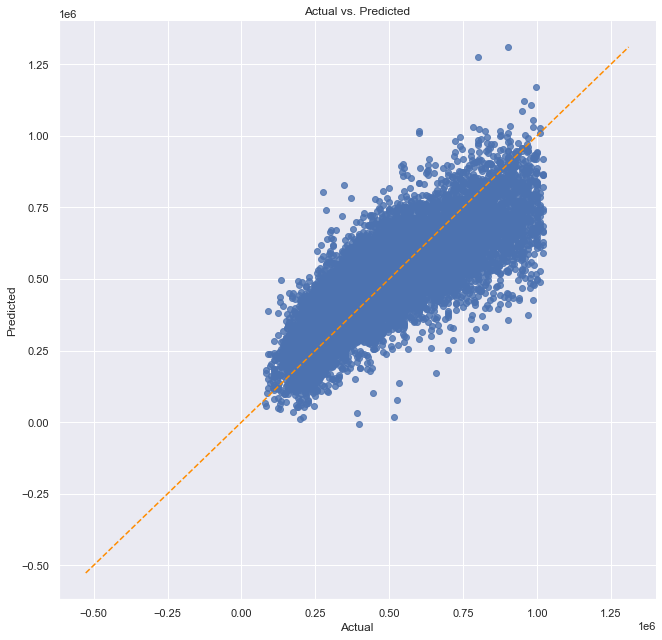

In [347]:
linear_assumption(final_model, x_train_final, y_train)

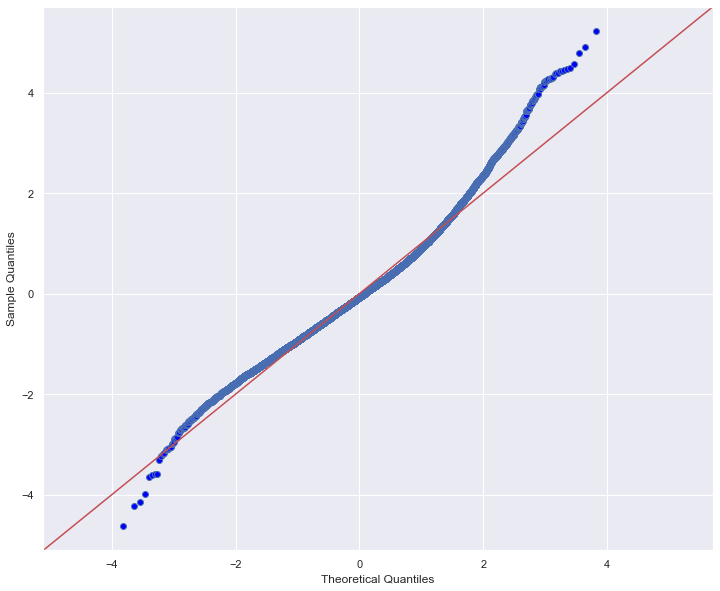

In [348]:
normality(final_model, x_train_final, y_train)

In [349]:
vif(x_train_final, y_train)

,feature,VIF
0,Intercept,4204604.2350
1,features[0],1.5668
2,features[1],2.8056
3,features[2],1.0847
4,features[3],1.5281
5,features[4],1.1906
6,features[5],2.4321
7,features[6],2.0117
8,features[7],1.6342
9,features[8],1.1490


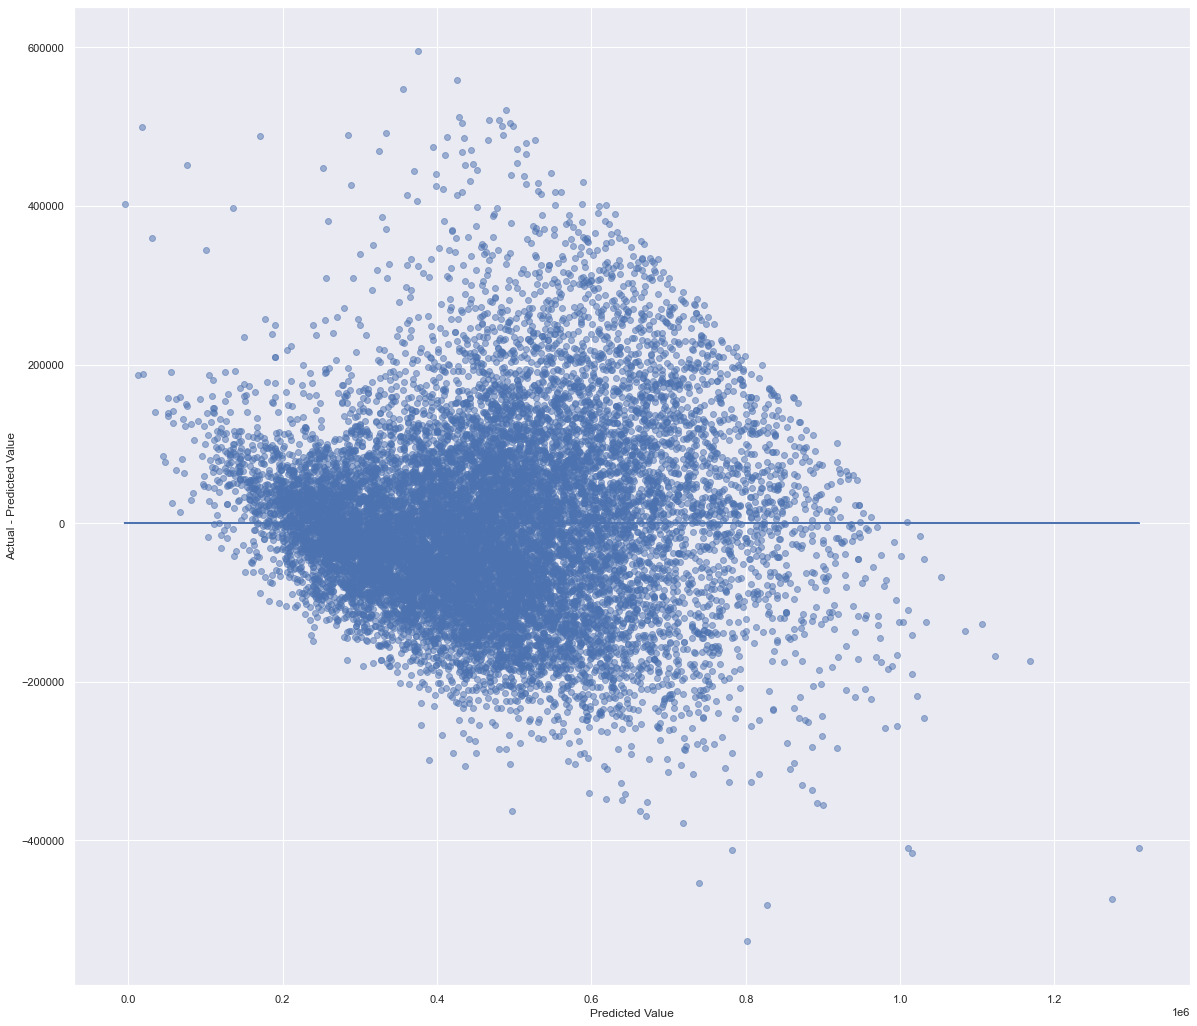

In [350]:
homoscedasticity(final_model, x_train_final, y_train)

#### Expecting One Hot Encoder to Further Improve R-squared

### Apply One Hot Encoder to Zipcode

In [356]:
df_test = df_copy.copy()
df_test = df_test.reset_index()
encoder = OneHotEncoder()
# apply on df
# color_1hot = encoder.fit_transform(df_clean["zipcode"].values.reshape(-1,1))
# color_1hot_df = pd.DataFrame(color_1hot.toarray())
# df_clean = pd.concat([df_clean.drop('zipcode', axis = 1), color_1hot_df], axis = 1)
zipcode_trans = encoder.fit_transform(df_test['zipcode'].values.reshape(-1,1))
zipcode_trans.todense()
encoder.get_feature_names()
zipcode_df =pd.DataFrame(zipcode_trans.todense(), columns = encoder.get_feature_names())
zipcode_df
df_test = df_test.join(zipcode_df)

endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1102.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        22:04:30   Log-Likelihood:            -2.5476e+05
No. Observations:               19981   AIC:                         5.097e+05
Df Residuals:                   19897   BIC:                         5.104e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.424e+07   3.25e+06     -4.376      0.000   -2.06e+07   -7.86e+06
index             0.2363      0.099      2.399      0.016       0.043       0.429
bedrooms      -4436.6785    852.749     -5.203      0.000   -6108.137   -2765.220
bathrooms      1.657e+04   1457.723     11.365      0.000    1.37e+04    1.94e+04
sqft_living      66.7956      2.076     32.181      0.000      62.727      70.864
sqft_lot          0.3000      0.021     14.290      0.000       0.259       0.341
floors        -1.354e+04   1744.066     -7.765      0.000    -1.7e+04   -1.01e+04
condition       2.18e+04   1035.328     21.057      0.000    1.98e+04    2.38e+04
grade          4.459e+04   1030.127     43.283      0.000    4.26e+04    4.66e+04
sqft_above       38.3979      2.099     18.293      0.000      34.283      42.512
yr_built       -682.4751     34.388    -19.846      0.000    -749.878    -615.072
lat            1.489e+05   3.42e+04      4.356      0.000    8.19e+04    2.16e+05
long          -6.954e+04   2.43e+04     -2.858      0.004   -1.17e+05   -2.18e+04
sqft_living15    42.0640      1.687     24.937      0.000      38.758      45.370
sqft_lot15        0.0122      0.033      0.367      0.713      -0.053       0.077
x0_98001      -3.487e+05   4.51e+04     -7.729      0.000   -4.37e+05    -2.6e+05
x0_98002      -3.389e+05    4.4e+04     -7.706      0.000   -4.25e+05   -2.53e+05
x0_98003      -3.561e+05   4.61e+04     -7.723      0.000   -4.47e+05   -2.66e+05
x0_98004       8.951e+04   4.77e+04      1.878      0.060   -3925.343    1.83e+05
x0_98005      -7.161e+04   4.69e+04     -1.526      0.127   -1.64e+05    2.04e+04
x0_98006      -1.158e+05   4.55e+04     -2.547      0.011   -2.05e+05   -2.67e+04
x0_98007      -1.405e+05   4.65e+04     -3.023      0.003   -2.32e+05   -4.94e+04
x0_98008      -1.446e+05   4.58e+04     -3.159      0.002   -2.34e+05   -5.49e+04
x0_98010      -2.501e+05      4e+04     -6.257      0.000   -3.28e+05   -1.72e+05
x0_98011      -2.726e+05      5e+04     -5.447      0.000   -3.71e+05   -1.74e+05
x0_98014      -2.676e+05   4.22e+04     -6.343      0.000    -3.5e+05   -1.85e+05
x0_98019      -2.941e+05   4.51e+04     -6.516      0.000   -3.83e+05   -2.06e+05
x0_98022      -3.046e+05   3.82e+04     -7.971      0.000    -3.8e+05    -2.3e+05
x0_98023      -3.791e+05   4.72e+04     -8.034      0.000   -4.72e+05   -2.87e+05
x0_98024      -2.148e+05   4.15e+04     -5.173      0.000   -2.96e+05   -1.33e+05
x0_98027      -1.814e+05   4.27e+04     -4.248      0.000   -2.65e+05   -9.77e+04
x0_98028      -2.829e+05   5.08e+04     -5.568      0.000   -3.82e+05   -1.83e+05
x0_98029      -1.448e+05   4.26e+04     -3.401      0.001   -2.28e+05   -6.13e+04
x0_98030      -3.497e+05    4.4e+04     -7.953      0.000   -4.36e+05   -2.64e+05
x0_98031      -3.506e+05   4.43e+04     -7.911   

Notice that the condition number is very big in this model, and we are sure that there is multicollinearity problem.
We are going to drop these variables with large p-value and see if it improves the model overall without sacrificing 
too much of predictive power. 

### Test score on our new model with One Hot Encoder

In [366]:
# Compute our model test score. The score is great, but we need to check if our model is reliable enough to provdie 
# statisticlly significant result.

X = df_test.drop('price', axis = 1)
y = df_test.price
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8272930615703111
0.8279573070551907


In [367]:
# Calculate the RMSE measure.
lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
print(np.sqrt(mean_squared_error(y, y_hat)))

83389.69953435204
83389.69953435191


### Assumption Tests with New Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


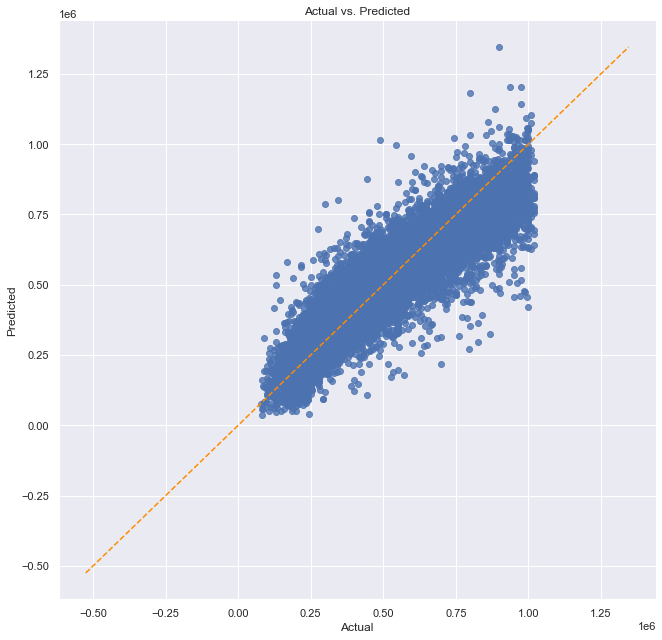

In [368]:
linear_assumption(lr, X, y)

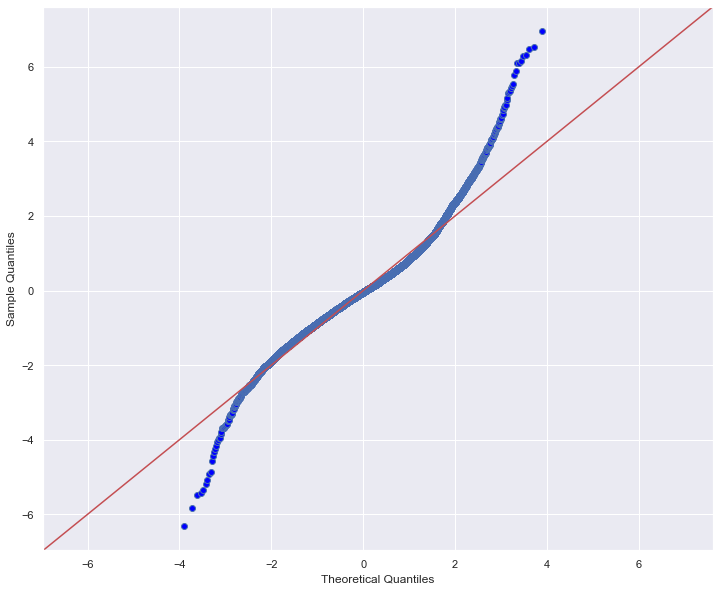

In [369]:
normality(lr, X, y)

In [370]:
# It seems that we are seeing some zeros that cause inf problem. It's not a big deal as we will tune our model and make it 
# more reliable.
vif_new(X, y)

C:\Users\Trader\anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Trader\anaconda3\envs\learn-env\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Intercept,0.0000
1,X[0],1.0769
2,X[1],1.7009
3,X[2],2.9947
4,X[3],7.0524
5,X[4],2.0329
6,X[5],2.5076
7,X[6],1.2762
8,X[7],3.0742
9,X[8],6.4047


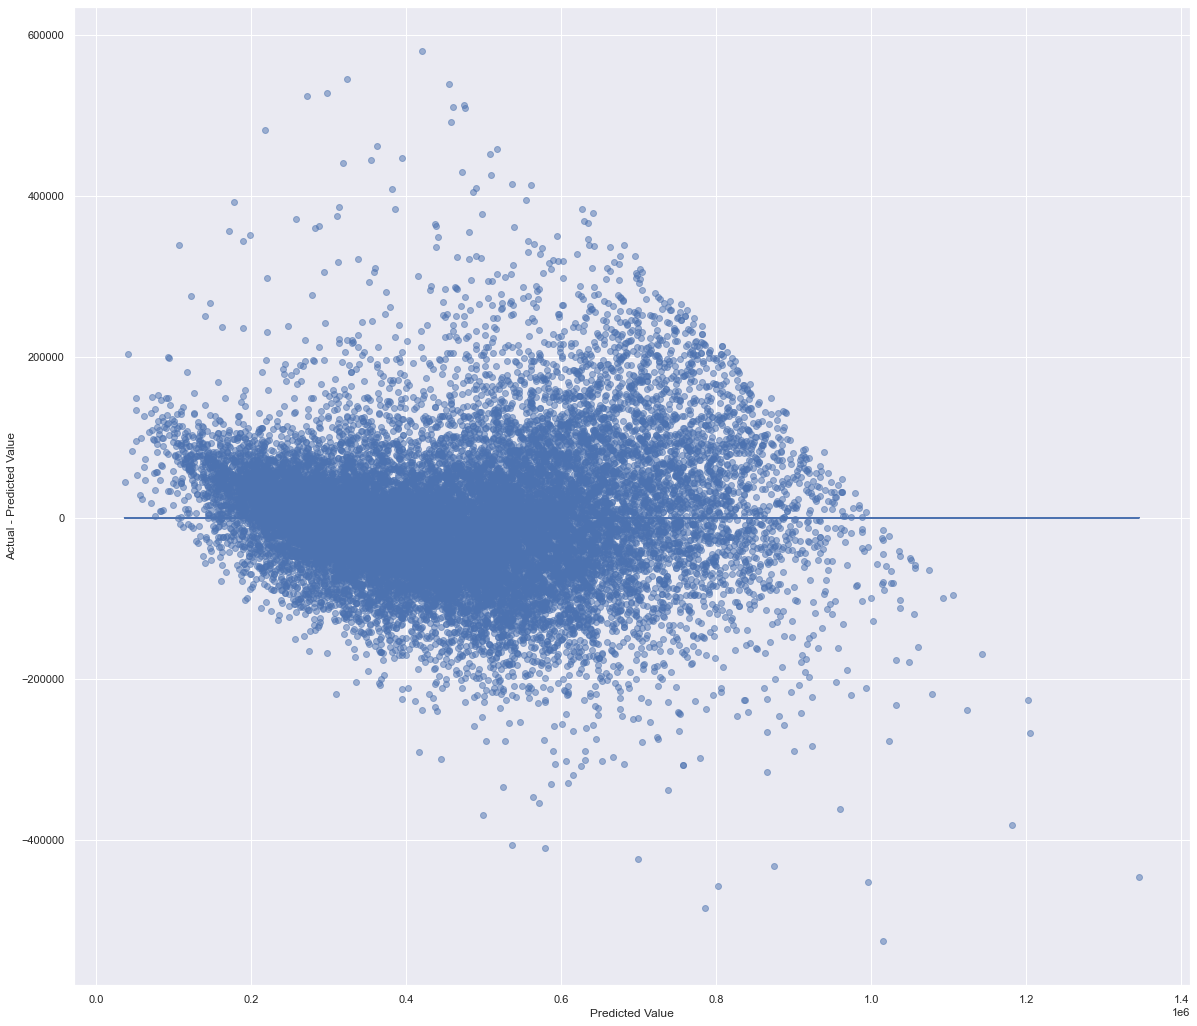

In [363]:
homoscedasticity(lr, X, y)

We are dropping the variables with P-Value > 0.05 and see if the model is improving.

In [364]:
endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1269.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        22:07:11   Log-Likelihood:            -2.5524e+05
No. Observations:               19981   AIC:                         5.106e+05
Df Residuals:                   19912   BIC:                         5.112e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           8.57e+06   2.33e+06      3.676      0.000       4e+06    1.31e+07
index             0.2345      0.101      2.326      0.020       0.037       0.432
bedrooms      -4043.4954    871.193     -4.641      0.000   -5751.106   -2335.885
bathrooms       1.63e+04   1489.862     10.944      0.000    1.34e+04    1.92e+04
sqft_living      65.3607      2.118     30.865      0.000      61.210      69.511
sqft_lot          0.2958      0.017     17.852      0.000       0.263       0.328
floors        -1.455e+04   1738.628     -8.368      0.000    -1.8e+04   -1.11e+04
condition      2.173e+04   1053.516     20.629      0.000    1.97e+04    2.38e+04
grade          4.562e+04   1048.363     43.512      0.000    4.36e+04    4.77e+04
sqft_above       37.0792      2.137     17.348      0.000      32.890      41.269
yr_built       -704.3152     34.267    -20.554      0.000    -771.481    -637.150
lat           -6.063e+04   2.53e+04     -2.396      0.017    -1.1e+05    -1.1e+04
long           3.563e+04   1.63e+04      2.186      0.029    3685.448    6.76e+04
sqft_living15    47.4693      1.702     27.887      0.000      44.133      50.806
x0_98001      -3.542e+05   9843.168    -35.988      0.000   -3.74e+05   -3.35e+05
x0_98002      -3.491e+05   1.08e+04    -32.444      0.000    -3.7e+05   -3.28e+05
x0_98003      -3.569e+05   9982.573    -35.757      0.000   -3.77e+05   -3.37e+05
x0_98006      -8.527e+04   5701.591    -14.956      0.000   -9.64e+04   -7.41e+04
x0_98007      -9.849e+04   8082.260    -12.186      0.000   -1.14e+05   -8.27e+04
x0_98008      -1.041e+05   6303.126    -16.509      0.000   -1.16e+05   -9.17e+04
x0_98010      -2.788e+05   1.28e+04    -21.826      0.000   -3.04e+05   -2.54e+05
x0_98011      -1.938e+05   7166.541    -27.044      0.000   -2.08e+05    -1.8e+05
x0_98014      -2.403e+05    1.1e+04    -21.831      0.000   -2.62e+05   -2.19e+05
x0_98019      -2.431e+05   8847.245    -27.478      0.000    -2.6e+05   -2.26e+05
x0_98022      -3.589e+05   1.34e+04    -26.822      0.000   -3.85e+05   -3.33e+05
x0_98023       -3.76e+05   9619.553    -39.088      0.000   -3.95e+05   -3.57e+05
x0_98024      -2.068e+05   1.24e+04    -16.659      0.000   -2.31e+05   -1.83e+05
x0_98027      -1.682e+05   6963.774    -24.152      0.000   -1.82e+05   -1.55e+05
x0_98028       -1.99e+05   6142.523    -32.391      0.000   -2.11e+05   -1.87e+05
x0_98029      -1.268e+05   7368.119    -17.205      0.000   -1.41e+05   -1.12e+05
x0_98030      -3.515e+05   9181.560    -38.280      0.000   -3.69e+05   -3.33e+05
x0_98031      -3.454e+05   8407.956    -41.075      0.000   -3.62e+05   -3.29e+05
x0_98032      -3.581e+05   1.05e+04    -34.021      0.000   -3.79e+05   -3.37e+05
x0_98034      -1.499e+05   4802.964    -31.210      0.000   -1.59e+05    -1.4e+05
x0_98038      -3.225e+05   9084.604    -35.499   

The condition number has definitely improved. However, it is still show the multicollinearity problem.

In [371]:
y = df_test.price
X = df_test.drop(labels=['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                         'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                         'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8232282492641338
0.8220177363335999


In [372]:
X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis = 1)
y = df_test.price

lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
print(np.sqrt(mean_squared_error(y, y_hat)))

85422.0523110628
85422.05231106262


### Running Assumption Tests on the Improved Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


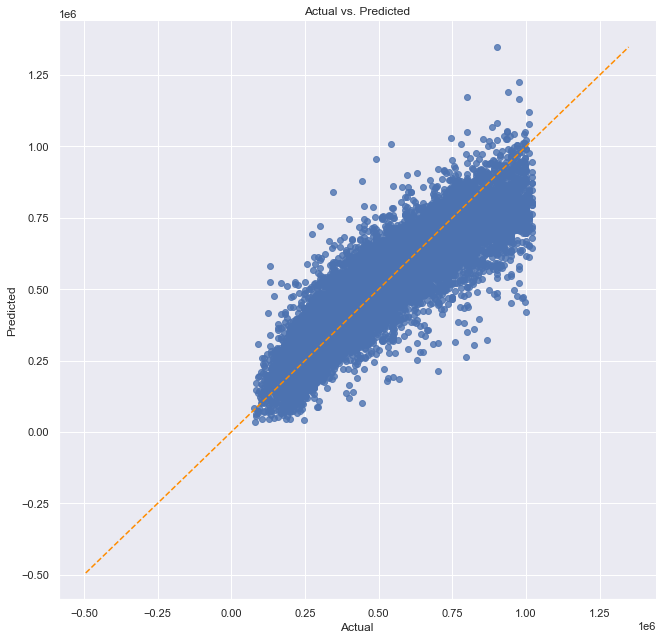

In [377]:
linear_assumption(lr, X, y)

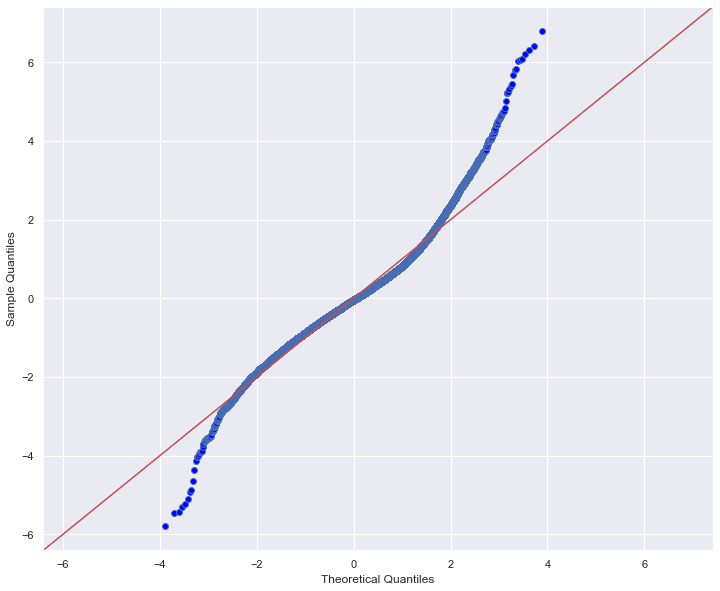

In [378]:
normality(lr, X, y)

#### Handling the Multicollinearity Problem

In [379]:
pd.set_option('display.max_rows', None)
vif_new(X, y)

,feature,VIF
0,Intercept,14833120.5942
1,X[0],1.0755
2,X[1],1.6930
3,X[2],2.9834
4,X[3],7.0005
5,X[4],1.2075
6,X[5],2.3766
7,X[6],1.2602
8,X[7],3.0366
9,X[8],6.3333


In [376]:
vif_new(X,y).sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,14833120.5942
11,X[10],35.0568
12,X[11],14.7056
4,X[3],7.0005
34,X[33],6.3794
9,X[8],6.3333
25,X[24],6.0286
24,X[23],5.6066
36,X[35],5.4483
50,X[49],4.8945


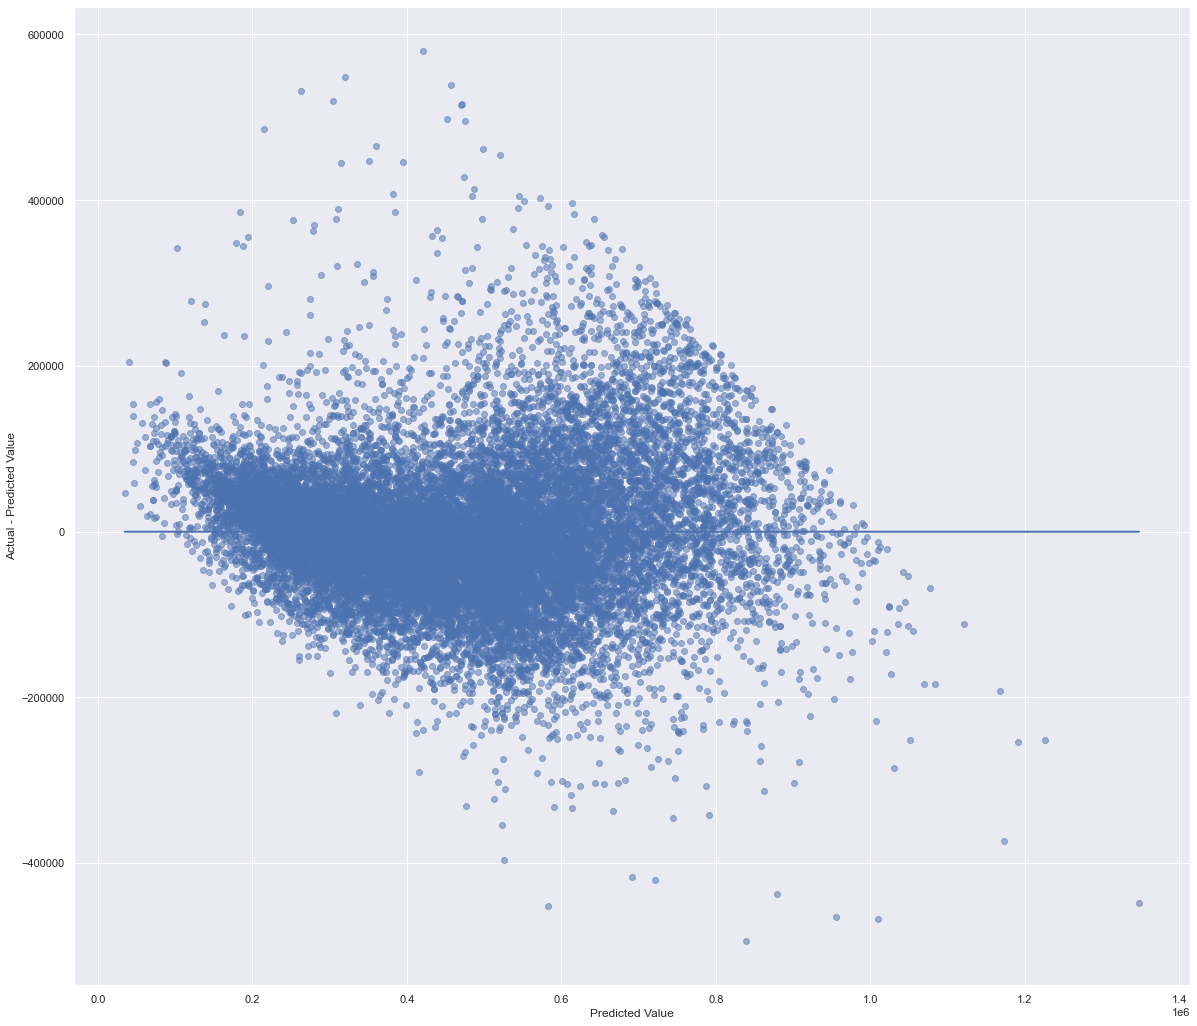

In [380]:
homoscedasticity(lr, X, y)

In [381]:
# Since we have mullticollinearity problem that is reflected on VIF scores. Instead of dropping them altogether, we started by
# dropping the variable with the highest vif score one by one. In this way, we can see how model reacts without remove 
# significant variable.

X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199', 'lat', 'long'], axis = 1)
vif_new(X,y).sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,11289.2751
4,X[3],6.9785
9,X[8],6.2433
8,X[7],3.0211
3,X[2],2.9807
11,X[10],2.8353
10,X[9],2.6477
6,X[5],2.3153
2,X[1],1.6902
32,X[31],1.3147


In [382]:
# Checking the conditional number and see if it improves.
endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199', 'lat', 'long'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1307.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        22:13:57   Log-Likelihood:            -2.5525e+05
No. Observations:               19981   AIC:                         5.106e+05
Df Residuals:                   19914   BIC:                         5.112e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.299e+06   6.43e+04     20.190      0.000    1.17e+06    1.42e+06
index             0.2239      0.101      2.222      0.026       0.026       0.421
bedrooms      -3947.7936    870.652     -4.534      0.000   -5654.345   -2241.243
bathrooms      1.624e+04   1489.513     10.901      0.000    1.33e+04    1.92e+04
sqft_living      65.0497      2.115     30.760      0.000      60.905      69.195
sqft_lot          0.2984      0.017     18.038      0.000       0.266       0.331
floors        -1.523e+04   1716.439     -8.872      0.000   -1.86e+04   -1.19e+04
condition      2.196e+04   1051.139     20.889      0.000    1.99e+04     2.4e+04
grade          4.548e+04   1045.906     43.484      0.000    4.34e+04    4.75e+04
sqft_above       37.6496      2.123     17.737      0.000      33.489      41.810
yr_built       -691.5867     33.825    -20.446      0.000    -757.887    -625.286
sqft_living15    47.9984      1.693     28.347      0.000      44.679      51.317
x0_98001       -3.33e+05   4905.070    -67.893      0.000   -3.43e+05   -3.23e+05
x0_98002      -3.257e+05   6403.132    -50.865      0.000   -3.38e+05   -3.13e+05
x0_98003      -3.375e+05   5453.371    -61.890      0.000   -3.48e+05   -3.27e+05
x0_98006      -7.509e+04   4761.839    -15.768      0.000   -8.44e+04   -6.58e+04
x0_98007      -9.096e+04   7646.987    -11.895      0.000   -1.06e+05    -7.6e+04
x0_98008       -9.59e+04   5557.946    -17.255      0.000   -1.07e+05    -8.5e+04
x0_98010      -2.496e+05   8910.686    -28.013      0.000   -2.67e+05   -2.32e+05
x0_98011      -1.973e+05   6434.554    -30.659      0.000    -2.1e+05   -1.85e+05
x0_98014      -2.262e+05   8278.740    -27.321      0.000   -2.42e+05    -2.1e+05
x0_98019      -2.367e+05   6558.391    -36.094      0.000    -2.5e+05   -2.24e+05
x0_98022      -3.222e+05   6042.606    -53.313      0.000   -3.34e+05    -3.1e+05
x0_98023      -3.582e+05   4279.758    -83.686      0.000   -3.67e+05    -3.5e+05
x0_98024      -1.877e+05   1.05e+04    -17.921      0.000   -2.08e+05   -1.67e+05
x0_98027      -1.518e+05   4729.702    -32.093      0.000   -1.61e+05   -1.43e+05
x0_98028      -2.039e+05   5422.603    -37.607      0.000   -2.15e+05   -1.93e+05
x0_98029      -1.112e+05   5232.637    -21.256      0.000   -1.21e+05   -1.01e+05
x0_98030      -3.311e+05   5714.506    -57.934      0.000   -3.42e+05    -3.2e+05
x0_98031       -3.27e+05   5536.181    -59.073      0.000   -3.38e+05   -3.16e+05
x0_98032      -3.409e+05   7942.529    -42.924      0.000   -3.56e+05   -3.25e+05
x0_98034      -1.514e+05   4161.976    -36.365      0.000    -1.6e+05   -1.43e+05
x0_98038      -2.967e+05   4125.027    -71.917      0.000   -3.05e+05   -2.89e+05
x0_98039       2.837e+05   3.83e+04      7.402      0.000    2.09e+05    3.59e+05
x0_98042      -3.272e+05   4180.072    -78.279   

In [383]:
# VIF has come out great, and we have reached our best model.
X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199', 
                  'lat', 'long', 'sqft_above'], axis = 1)
vif_new(X,y).sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,11269.8877
4,X[3],4.3658
8,X[7],2.9509
3,X[2],2.8992
10,X[9],2.7711
9,X[8],2.6374
6,X[5],1.7754
2,X[1],1.6899
31,X[30],1.2751
7,X[6],1.2480


In [384]:
#checking the predicative capability of our ultimate model.

y = df_test.price
X = df_test.drop(labels=['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                         'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                         'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199',
                         'lat', 'long', 'sqft_above'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8217180512836258
0.8199397832669874


In [385]:
X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199',
                  'lat', 'long', 'sqft_above'], axis = 1)
y = df_test.price

lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
print(np.sqrt(mean_squared_error(y, y_hat)))

86117.09983470035
86117.0998347001


In [386]:
# checking our conditional no. from this model.
endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199', 
                                    'lat', 'long','sqft_above'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1302.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        22:16:05   Log-Likelihood:            -2.5541e+05
No. Observations:               19981   AIC:                         5.109e+05
Df Residuals:                   19915   BIC:                         5.115e+05
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.346e+06   6.48e+04     20.780      0.000    1.22e+06    1.47e+06
index             0.2154      0.102      2.122      0.034       0.016       0.414
bedrooms      -3754.9245    877.412     -4.280      0.000   -5474.726   -2035.123
bathrooms      1.187e+04   1480.542      8.017      0.000    8967.710    1.48e+04
sqft_living      88.0008      1.686     52.202      0.000      84.697      91.305
sqft_lot          0.3051      0.017     18.305      0.000       0.272       0.338
floors         -525.7463   1514.818     -0.347      0.729   -3494.916    2443.424
condition      2.066e+04   1056.827     19.552      0.000    1.86e+04    2.27e+04
grade          4.831e+04   1041.795     46.370      0.000    4.63e+04    5.03e+04
yr_built       -729.1045     34.024    -21.429      0.000    -795.794    -662.415
sqft_living15    52.5176      1.687     31.129      0.000      49.211      55.824
x0_98001      -3.223e+05   4905.927    -65.698      0.000   -3.32e+05   -3.13e+05
x0_98002      -3.122e+05   6407.326    -48.719      0.000   -3.25e+05      -3e+05
x0_98003      -3.287e+05   5473.476    -60.060      0.000   -3.39e+05   -3.18e+05
x0_98006      -7.097e+04   4793.470    -14.805      0.000   -8.04e+04   -6.16e+04
x0_98007      -8.266e+04   7692.510    -10.745      0.000   -9.77e+04   -6.76e+04
x0_98008      -8.806e+04   5583.782    -15.770      0.000    -9.9e+04   -7.71e+04
x0_98010      -2.357e+05   8945.532    -26.344      0.000   -2.53e+05   -2.18e+05
x0_98011       -1.89e+05   6468.129    -29.227      0.000   -2.02e+05   -1.76e+05
x0_98014      -2.138e+05   8313.979    -25.717      0.000    -2.3e+05   -1.98e+05
x0_98019      -2.253e+05   6578.163    -34.257      0.000   -2.38e+05   -2.12e+05
x0_98022      -3.083e+05   6038.825    -51.051      0.000    -3.2e+05   -2.96e+05
x0_98023      -3.498e+05   4287.223    -81.596      0.000   -3.58e+05   -3.41e+05
x0_98024      -1.749e+05   1.05e+04    -16.609      0.000   -1.95e+05   -1.54e+05
x0_98027      -1.473e+05   4759.842    -30.938      0.000   -1.57e+05   -1.38e+05
x0_98028      -1.973e+05   5451.952    -36.180      0.000   -2.08e+05   -1.87e+05
x0_98029      -1.021e+05   5247.944    -19.449      0.000   -1.12e+05   -9.18e+04
x0_98030      -3.197e+05   5723.048    -55.862      0.000   -3.31e+05   -3.08e+05
x0_98031      -3.175e+05   5553.139    -57.172      0.000   -3.28e+05   -3.07e+05
x0_98032      -3.347e+05   7996.924    -41.850      0.000    -3.5e+05   -3.19e+05
x0_98034      -1.438e+05   4172.351    -34.454      0.000   -1.52e+05   -1.36e+05
x0_98038       -2.84e+05   4094.305    -69.356      0.000   -2.92e+05   -2.76e+05
x0_98039       2.861e+05   3.86e+04      7.407      0.000     2.1e+05    3.62e+05
x0_98042      -3.147e+05   4151.993    -75.784      0.000   -3.23e+05   -3.07e+05
x0_98045      -2.101e+05   6219.230    -33.782   

We have tuned down the conditional number from 9.62e+15 to 4.57e+06, though the multicollinearity is still present. We believed that these variables are individually communicating to the model and generating similar predictive power = 82% vs 82.8%(with much higher conditional number).



## Conclusion